!pip instal sonnet

In [1]:
!pip install dm-sonnet tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 KB 5.8 MB/s eta 0:00:00


Importing libraries

In [2]:
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds

Dataset preparations

In [3]:
batch_size = 100

def process_batch(images, labels):
  images = tf.squeeze(images, axis=[-1])
  images = tf.cast(images, dtype=tf.float32)
  images = ((images / 255.) - .5) * 2.
  return images, labels

def mnist(split):
  dataset = tfds.load("mnist", split=split, as_supervised=True)
  dataset = dataset.map(process_batch)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache()
  return dataset

mnist_train = mnist("train").shuffle(10)
mnist_test = mnist("test")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


plotting the images

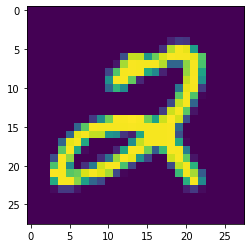

In [4]:
import matplotlib.pyplot as plt

images, _ = next(iter(mnist_test))
plt.imshow(images[0]);

Building a model

In [5]:
class MLP(snt.Module):

  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = snt.Flatten()
    self.hidden1 = snt.Linear(1024, name="hidden1")
    self.hidden2 = snt.Linear(1024, name="hidden2")
    self.logits = snt.Linear(101, name="logits")

  def __call__(self, images):
    output = self.flatten(images)
    output = tf.nn.relu(self.hidden1(output))
    output = tf.nn.relu(self.hidden2(output))
    output = self.logits(output)
    return output

Creating a model instance

In [6]:
mlp = MLP()
mlp

MLP()

forward pass

Predicted class: 88 actual class: 2


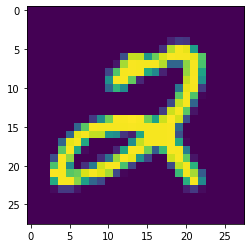

In [7]:
images, labels = next(iter(mnist_test))
logits = mlp(images)
  
prediction = tf.argmax(logits[0]).numpy()
actual = labels[0].numpy()
print("Predicted class: {} actual class: {}".format(prediction, actual))
plt.imshow(images[0]);

In [8]:
#@title Utility function to show progress bar.
from tqdm import tqdm

# Caltech101 training set has 9k images.
num_images = 9000

def progress_bar(generator):
  return tqdm(
      generator,
      unit='images',
      unit_scale=batch_size,
      total=(num_images // batch_size) * num_epochs)

In [10]:
opt = snt.optimizers.SGD(learning_rate=0.1)

num_epochs = 10

def step(images, labels):
  """Performs one optimizer step on a single mini-batch."""
  with tf.GradientTape() as tape:
    logits = mlp(images)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=labels)
    loss = tf.reduce_mean(loss)

  params = mlp.trainable_variables
  grads = tape.gradient(loss, params)
  opt.apply(grads, params)
  return loss

for images, labels in progress_bar(mnist_train.repeat(num_epochs)):
  loss = step(images, labels)

print("\n\nFinal loss: {}".format(loss.numpy()))

600000images [05:21, 1863.64images/s]



Final loss: 0.0074286446906626225


# Evaluating the model

In [11]:
total = 0
correct = 0
for images, labels in mnist_test:
  predictions = tf.argmax(mlp(images), axis=1)
  correct += tf.math.count_nonzero(tf.equal(predictions, labels))
  total += images.shape[0]

print("Got %d/%d (%.02f%%) correct" % (correct, total, correct / total * 100.))

Got 9809/10000 (98.09%) correct


In [12]:
#@title Utility function to show a sample of images.
def sample(correct, rows, cols):
  n = 0

  f, ax = plt.subplots(rows, cols)
  if rows > 1:    
    ax = tf.nest.flatten([tuple(ax[i]) for i in range(rows)])
  f.set_figwidth(14)
  f.set_figheight(4 * rows)


  for images, labels in mnist_test:
    predictions = tf.argmax(mlp(images), axis=1)
    eq = tf.equal(predictions, labels)
    for i, x in enumerate(eq):
      if x.numpy() == correct:
        label = labels[i]
        prediction = predictions[i]
        image = images[i]

        ax[n].imshow(image)
        ax[n].set_title("Prediction:{}\nActual:{}".format(prediction, label))

        n += 1
        if n == (rows * cols):
          break

    if n == (rows * cols):
      break

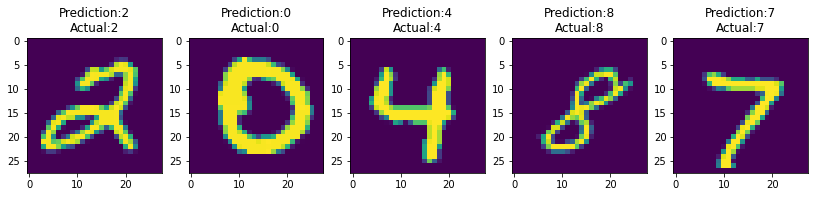

In [13]:
sample(correct=True, rows=1, cols=5)

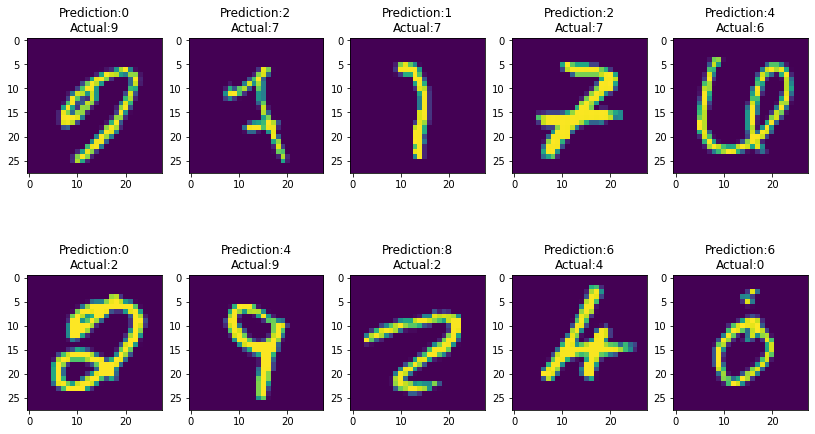

In [14]:
sample(correct=False, rows=2, cols=5)